# Midterm Progress For Master Thesis 
# "Machine Learning Approach to Polkadots Validator Election Algorithm"

### 1. Introduction

 - Polkadot election of active set of validators occurs every 24 hours.
 - The active set of validators is the set of validators that are eligible to produce blocks in the next 24 hours.
     - The active set is currently chosen by the Sequential Phragmén algorithm.
     - The Phragmén algorithm is an iterative method for electing a committee with proportional justified representation.
     
- The current configuration allows for a "staking miner" (role in experimental phase) to propose solutions to the system. 
 
     - The staking miner is incentivised to propose solutions that are as close to the optimal solution as possible.

 - Each solution has a "security score" which is determined by 3 factors:
     1. maximise: the minimally staked validator of the active set
     2. maximise: the sum of stakes of the active set
     3. minimise: the variance of the stakes of the active set
 - The criteria get judged in order and as soon as one of the criteria is not met, the solution is rejected.



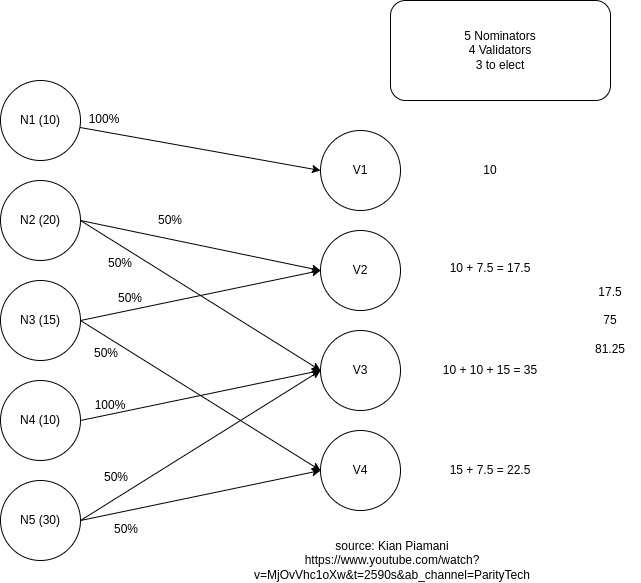

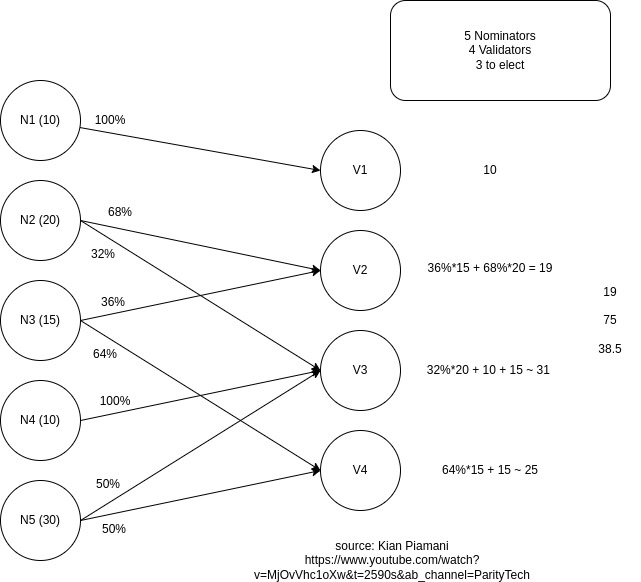

#### Breakdown into three parts:
 1. Pipeline
 2. Model1: Classification model: Active Set prediciton
 3. Model2: Regression model: Prediction of Stake (vote) distribution


# Pipeline

Data Acquisition via storage queries (takes about 8 hours to gather data for 1 year)
 - Snapshot of Nominators, their stake and their vote preferences (up to 16 validators) (leads to graph of max 22'500 nominators with max 16 votes == 360'000 edges per day)
 - SolutionStored: The solution posted by staking miner by running sequential phragmén algorithm
 - Local Sequential Phragmén: Running the sequential phragmén algorithm locally for a longer time to acquire a better solution than the one posted by the staking miner
 - automatic snapshot acquisition via subscription of storage queries

Data Preprocessing
 - Feature engineering, Feature selection, Feature scaling
 - Index mapping (validator+nominator address to index)
 - Restructuring of data to avoid curse of dimensionality (one-hot encoding of votes)

Model Selection, Training & Prediction
 - user may select various models
 - model hyperparameters are previously tuned via optuna framework
 

In [2]:
import sys
!{sys.executable} -m pip install cvxpy

     |████████████████████████████████| 4.0 MB 2.1 MB/s eta 0:00:01
     |████████████████████████████████| 10.7 MB 24.6 MB/s eta 0:00:01
  Using cached setuptools-67.6.1-py3-none-any.whl (1.1 MB)
     |████████████████████████████████| 298 kB 27.7 MB/s eta 0:00:01
     |████████████████████████████████| 220 kB 20.3 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 24.8 MB/s eta 0:00:01
  Attempting uninstall: setuptools
    Found existing installation: setuptools 58.0.4
    Uninstalling setuptools-58.0.4:
      Successfully uninstalled setuptools-58.0.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 5.1.5 requires pyqt5<5.13, which is not installed.
spyder 5.1.5 requires pyqtwebengine<5.13, which is not installed.
conda-repo-cli 1.0.4 requires pathlib, which is not installed.
anaconda-project 0.10.1 requires ruamel-yaml, which is not inst

In [3]:
import pandas as pd
import cvxpy as cp

Adjustment
 - Predictions do not add up to 100%
 - Example:
     - Nominator X votes for 2 validators y and z with bond 100
     - Solution derived by seq. Phragmén dictates y receives 60, z receives 40
     - Prediction by model dictates y receives 40, z receives 40
         - 20 is missing, hence solution will not be accepted, must be adjusted!
 - various trivial (sub-)strategies implemented
     - "even_split"
     - "weighted_split"
     - "negative_adjustment"
     - cvxpy
         - objective function: L2 norm of the difference between the predicted values and the original predictions
         - always adds up to the corresponding target value (total bond), while also minimizing the difference between the original predictions and the optimized predictions
  
     

In [11]:
data = pd.DataFrame({
    'nominator': ['X', 'X', 'Y', 'Y', 'Z', 'Z'],
    'validator': ['Y', 'Z', 'X', 'Z', 'X', 'Y'],
    'total_bond': [80, 80, 100, 100, 180, 180],
    'solution_bond': [40, 40, 50, 50, 50, 130],
    'prediction': [20, 140, 50, 50, 10, 100]
})
data

,nominator,validator,total_bond,solution_bond,prediction
0,X,Y,80,40,20
1,X,Z,80,40,140
2,Y,X,100,50,50
3,Y,Z,100,50,50
4,Z,X,180,50,10
5,Z,Y,180,130,100


In [12]:
# Define variables
pred = cp.Variable(len(data))

# Define constraints
constraints = []
for n, g in data.groupby(['nominator']):
    idx = g.index
    target = g['total_bond'].iloc[0]
    constraints.append(cp.sum(pred[idx]) == target)

#constraints.append(cp.sum(pred) == cp.sum(data['target']))

# Define objective
objective = cp.Minimize(cp.norm(pred - data['prediction']))

# Solve optimization problem
problem = cp.Problem(objective, constraints)
problem.solve()

# Get optimized predictions
data['optimized_prediction'] = pred.value

In [13]:
data

,nominator,validator,total_bond,solution_bond,prediction,optimized_prediction
0,X,Y,80,40,20,-20.0
1,X,Z,80,40,140,100.0
2,Y,X,100,50,50,50.0
3,Y,Z,100,50,50,50.0
4,Z,X,180,50,10,45.0
5,Z,Y,180,130,100,135.0


Scoring & comparing (by 3 metrics)
 - maximise: minimally backed validator
 - maximise: sum of stakes
 - minimise: variance of stakes

(optional) Push solution to chain
 - essentially acting as a "staking miner"


# 1. Model 1: Classification model: Active Set Prediction --> (297/~1000) every 24 hours (done)
## 1.1 Data Acquisition via storage queries (takes about 8 hours to gather data for 1 year)
#### 1.1.1 Snapshot of Nominators, their stake and their vote preferences (up to 16 validators) (leads to graph of max 22500 nominators with max 16 votes == 360000 edges per day)
#### 1.1.2 SolutionStored: The solution posted by staking miner by running sequential phragmén algorithm
#### 1.1.3 Local Sequential Phragmén: Running the sequential phragmén algorithm locally for a longer time to acquire a better solution than the one posted by the staking miner
## 1.2 Data Preprocessing
### 1.2.1 Feature engineering, Feature selection, Feature scaling
### 1.2.2 Index mapping (validator+nominator address to index)
### 1.2.3 Restructuring of data to avoid curse of dimensionality (one-hot encoding of votes)
## 1.3 Exploratory Data Analysis
### 1.3.1 Pairwise comparison of active set
### 1.3.2 Cumulative elected validator distribution
### 1.3.3 Validator election frequency distribution
## 1.4 Model Selection, Training & Prediction
### 1.4.1 Random Forest Classifier
### 1.4.2 Logistic Regression

# 2. Model 2: Regression model:     Prediction of Stake ("vote") distribution amongst the active set (in progress)
## 2.1 Data Acquisition
### 2.1.1 trivial, can take previously acquired data and transform for regression model
## 2.2 Data Preprocessing
### 2.2.1 Feature engineering, Feature selection, Feature scaling
## 2.3 Exploratory Data Analysis
###
## 2.4 Model Selection, Training & Prediction
### 2.4.1 Optuna for hyperparameter tuning (Model and hyperparameter selection) guided by fitness function of 3 metrics (currently 1 metric)

# 3. Pipeline (in progress)
# Data acquisition --> Data preprocessing (both models) --> Model selection --> Model training & prediction (first active set then distribution) --> Model evaluation (scoring by 3 metrics) --> comparison with current solution --> pushing of solution to chain
## 3.1 Data Acquisition
### 3.1.1 automatic snapshot acquisition via subscription of storage queries (90% done)
## 3.2 Configuration via pyproject.toml
## 3.3 Future Work
### 3.3.1 Finishing of pipeline, ensuring modular design thus enabling connection to various blockchains and executing any predictions on the chain. (in progress)
### 3.3.2 Potentially looking into NEAT (NeuroEvolution of Augmenting Topologies) for model selection. Since data might not be informative enough for trivial models, NEAT might be able to produce more accurate/or more close predictions to the optimal solution. (in progress)


## 0. Importing the libraries


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Model 1: Active Set Prediction


## 1.1 Data Preprocessing

In [2]:
df = pd.read_csv("../data_collection/snapshot_with_solution.csv")
df.rename(columns={'Unnamed: 0': 'validator'}, inplace=True)
df.drop(columns=['self_stake'], inplace=True)

## 1.2 Exploratory Data Analysis

In [3]:
# In order to avoid curse of dimensionality, we need to restructure the data.
df.head()

,validator,total_bond,proportional_bond,list_of_nominators,nominator_count,elected_current_era,elected_previous_era,elected_counter,avg_stake_per_nominator,era
0,1zugcag7cJVBtVRnFxv5Qftn7xKAnR6YJ9x4x3XLgGgmNnS,173428979826227580,1.434129e+16,{'1SdEjEWdfJCisR9FpnpgAoTAEUKAivLSFj2sRMeKWxXm...,1468,1,0,0,9.769268e+12,590
1,16HxQKtm8FogERURhxaJ7n6dnvzVjnXcHP54nBFSFr6ZCqUh,950993578466105,1.041153e+14,{'1eE4N8j5sF3W1N3bf535hZ7VMpGbwyBD4MLXsKB5pxWP...,16,0,0,0,6.507203e+12,590
2,148Ta5cWD3wekK3C6EbdDhYrdxC5e71VTKQCjmHUjE1DCG31,130773957029866447,2.031984e+16,{'12YdvQC6ripH1RnnykQnoDSqyKyy7qX8gAR7ixLAumGs...,61,1,0,0,3.331121e+14,590
3,1uFscCqjzMDDGRS8bh9W8f4t94WVXgvnzTeSTrdjC8fJZA6,972806309572318,1.335135e+14,{'1M1vsos73tp6pp3zymbrxP2bAfeszLShuURcitbHTRmZ...,138,0,0,0,9.674891e+11,590
4,123viL2RvWMFmCQQBzii6JzDUPbL6MZQa27q2VWvBpkrRran,912207170000000,1.013652e+14,{'1s1SGPC2v5pYfcDNQKFhNiscsiu9VRZVywxaAgXJuKzE...,2,0,0,0,5.068262e+13,590


## model training & prediction

In [32]:
scaled_df = df.copy()

#scaled_df = scaled_df.loc[scaled_df['elected_counter'] == 1]
features = ['proportional_bond','elected_previous_era','elected_counter']


x = scaled_df.loc[:, features].values
y = scaled_df.loc[:, "elected_current_era"].values
x.shape

(492271, 3)

In [33]:
x_scaled = StandardScaler().fit_transform(x)
x_scaled

array([[ 1.13475075, -0.55080885, -0.40957088],
       [-0.61451042, -0.55080885, -0.40957088],
       [ 1.8693106 , -0.55080885, -0.40957088],
       ...,
       [-0.62727084, -0.55080885, -0.40957088],
       [-0.62727752, -0.55080885, -0.40957088],
       [-0.6272739 , -0.55080885, -0.40957088]])

In [34]:
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)


In [35]:
from sklearn.model_selection import cross_val_score

In [36]:
y_test.shape
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)


RandomForestClassifier(max_depth=2, random_state=0)

In [37]:
scores = cross_val_score(clf, x_scaled, y, cv=10)

print("%0.6f accuracy with a standard deviation of %0.6f" % (scores.mean(), scores.std()))

0.996291 accuracy with a standard deviation of 0.002779


In [31]:
scores = cross_val_score(clf, x_scaled, y, cv=10)

print("%0.6f accuracy with a standard deviation of %0.6f" % (scores.mean(), scores.std()))

0.957716 accuracy with a standard deviation of 0.003152


### 1.2.1 Pairwise comparison of active set

In [ ]:
era_index = []
set_difference = []
for i in range(590,950):
    df1 = set(df[(df['era'] == i) & (df['elected_current_era'] == 1)]['validator'])
    df2 = set(df[(df['era'] == i+1) & (df['elected_current_era'] == 1)]['validator'])
    era_index.append(i)
    set_difference.append(len(df1.difference(df2)))
plt.title("pairwise difference of active sets")
plt.xlabel("era_index")
plt.ylabel("count")

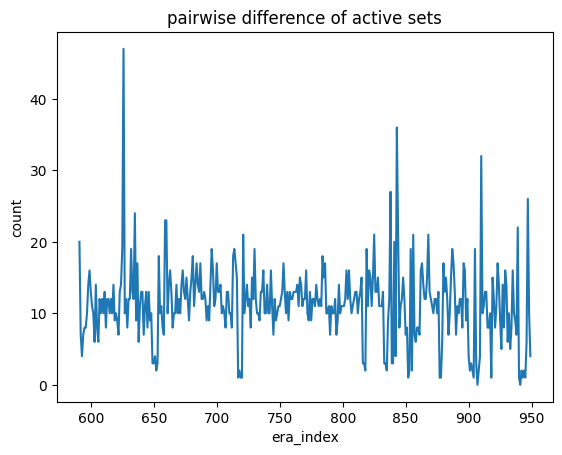

In [4]:
plt.plot(era_index[1:], set_difference[1:])

In [5]:
# set the elected counter equal at all validators of same address.
validators = set(df.validator.unique())
count_adapted_df = df.copy()
for validator in validators:
    counters = set(count_adapted_df.loc[count_adapted_df['validator'] == validator].elected_counter)
    maxcounter = max(counters)
    count_adapted_df.loc[count_adapted_df['validator'] == validator, 'elected_counter'] = maxcounter

### 1.2.2 Cumulative elected validator distribution

Text(0.5, 1.0, 'Cumulative elected validator distribution')

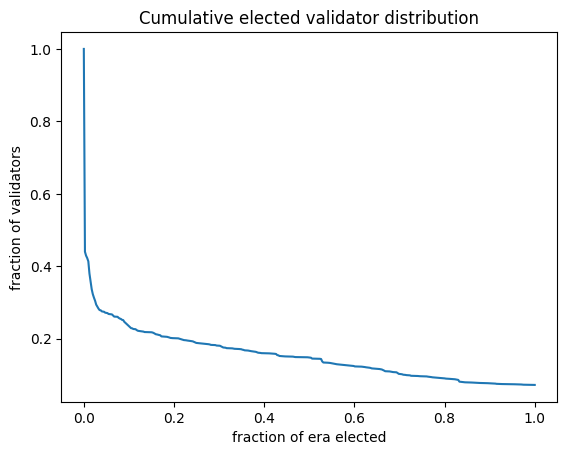

In [6]:
grouped_df = count_adapted_df.copy()
#df55 = df55[df55['elected_counter'] != 374]
grouped_df= grouped_df.groupby(['validator', 'elected_counter']).count().reset_index()
grouped_df = grouped_df.elected_counter.value_counts().sort_index(ascending=False).reset_index()

grouped_df['index'] = grouped_df['index'].div(grouped_df['index'].max())
grouped_df['elected_counter'] = grouped_df['elected_counter'].div(grouped_df['elected_counter'].sum())
#plt.hist(grouped_df['index'], 200, histtype="stepfilled", alpha=.7, cumulative=-1)
cumsum = np.cumsum(grouped_df['elected_counter'])
plt.plot(grouped_df['index'], cumsum, )
plt.xlabel('fraction of era elected')
plt.ylabel('fraction of validators')
plt.title('Cumulative elected validator distribution')


### 1.2.3 Validator election frequency distribution

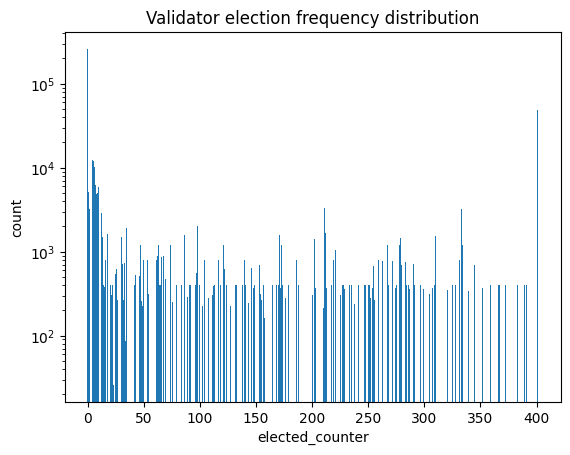

In [7]:
df2 = count_adapted_df.groupby(["elected_counter"]).size().reset_index(name='counter')
plt.bar(df2['elected_counter'], df2['counter'])
plt.xlabel("elected_counter")
plt.ylabel("count")
plt.yscale('log')
plt.title("Validator election frequency distribution")
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.show()

In [ ]:
features = ["total_bond", "proportional_bond", "nominator_count",
           "elected_counter", "avg_stake_per_nominator", "elected_previous_era", "elected_current_era"]
heatmap_df = df.loc[:,features]

<Axes: >

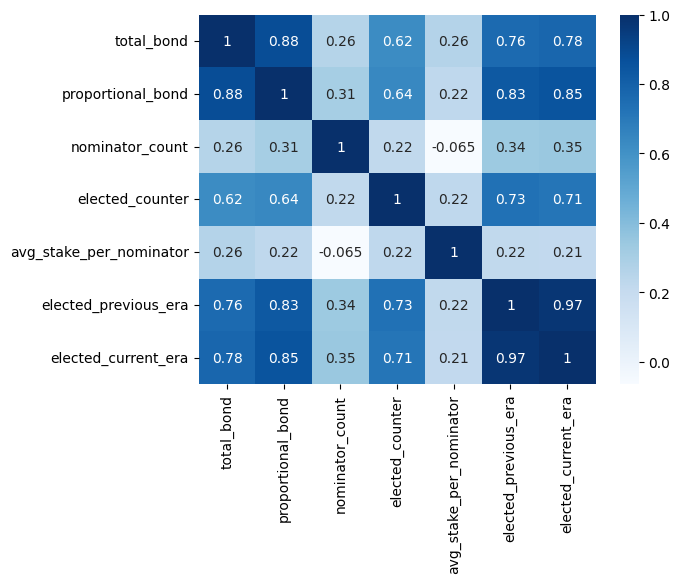

In [16]:
sns.heatmap(heatmap_df.corr(), cmap="Blues", annot=True)

# Description of absolute losers (elected_counter == 0)

In [17]:
loser_df = count_adapted_df.copy()
loser_df = loser_df.loc[(loser_df['elected_counter'] == 0) & (loser_df['elected_current_era'] == 0)]
describe_loser_df = loser_df.describe()
describe_loser_df.reset_index(inplace=True)
describe_loser_df = describe_loser_df[describe_loser_df['index'] != 'count']
describe_loser_df.columns

Index(['index', 'total_bond', 'proportional_bond', 'nominator_count',
       'elected_current_era', 'elected_previous_era', 'elected_counter',
       'avg_stake_per_nominator', 'era'],
      dtype='object')

## Description of Winners (elected_counter == 374)

In [18]:
winner_df = count_adapted_df.copy()
winner_df = winner_df.loc[winner_df['elected_counter'] == 401]
describe_winner_df = winner_df.describe()
describe_winner_df.reset_index(inplace=True)
describe_winner_df = describe_winner_df[describe_winner_df['index'] != 'count']


In [19]:
#winner_df.describe().to_frame('data').boxplot(meanline=True, showmeans=True)
#describe_winner_df['total_bond'].to_frame('data').boxplot(meanline=True, showmeans=True)
concated_dfs = []
for index, column in enumerate(describe_winner_df.columns):
    concated_dfs.append(pd.concat([describe_winner_df[column], describe_loser_df[column]], axis=1))
    concated_dfs[index].columns = ["winner", "loser"]

Text(0.5, 1.0, 'total bond')

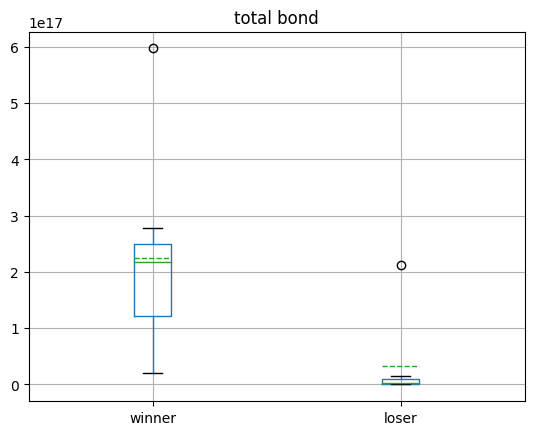

In [20]:
concated_dfs[1].boxplot(meanline=True, showmeans=True)
plt.title("total bond")

Text(0.5, 1.0, 'proportional bond')

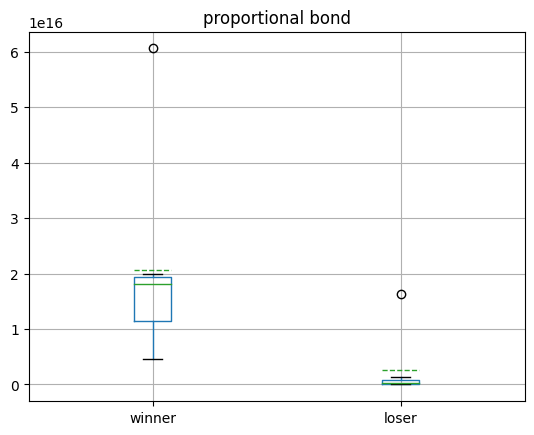

In [21]:
concated_dfs[2].boxplot(meanline=True, showmeans=True)
plt.title("proportional bond")

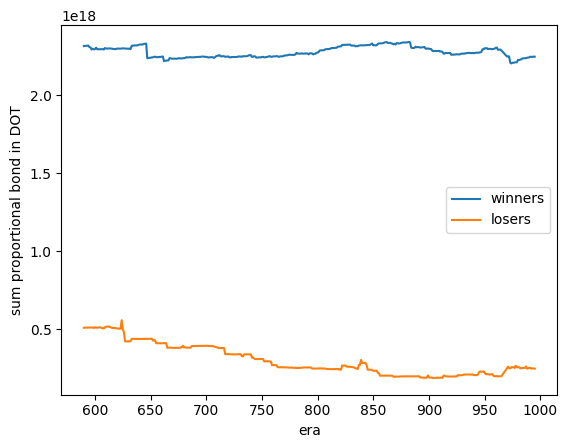

In [24]:
proportional_bonds_winners = winner_df.groupby("era").sum('proportional_bond').reset_index()
proportional_bonds_losers = loser_df.groupby("era").sum('proportional_bond').reset_index()
plt.plot(proportional_bonds_winners['era'], proportional_bonds_winners['proportional_bond'])
plt.plot(proportional_bonds_losers['era'], proportional_bonds_losers['proportional_bond'])
plt.xlabel("era")
plt.ylabel("sum proportional bond in DOT")
plt.legend(["winners", "losers"])
plt.show()

Text(0.5, 1.0, 'nominator count')

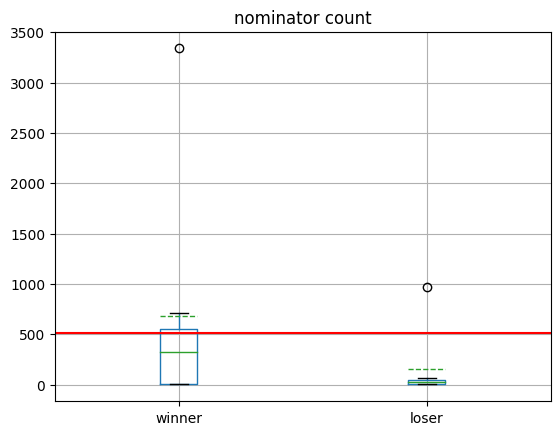

In [63]:
# oversubscribed after 512
concated_dfs[3].boxplot(meanline=True, showmeans=True)
plt.axhline(512, c='r')
plt.title("nominator count")

Text(0.5, 1.0, 'avg stake')

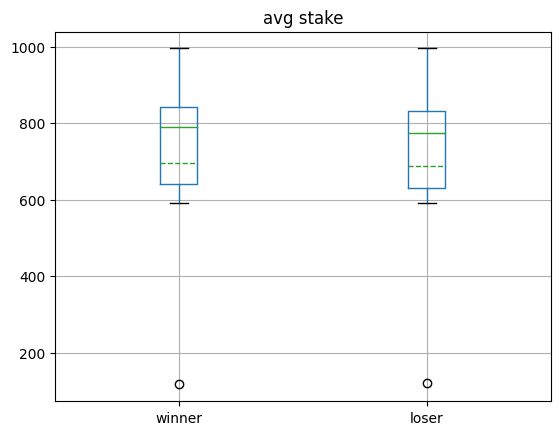

In [23]:
concated_dfs[8].boxplot(meanline=True, showmeans=True)
plt.title("avg stake")

# Model2: Regression model: Prediction of Stake (vote) distribution

In [ ]:
df = pd.read_csv("../data_collection/data/model_2/df_bond_distribution_1.csv")
df.drop(["Unnamed: 0"], axis=1, inplace=True)

In [65]:
df.head()

,nominator,validator,era,proportional_bond,number_of_validators,total_bond,solution_bond,prev_min_stake,prev_sum_stake,prev_variance_stake,total_proportional_bond
0,1zugcag7cJVBtVRnFxv5Qftn7xKAnR6YJ9x4x3XLgGgmNnS,1zugcag7cJVBtVRnFxv5Qftn7xKAnR6YJ9x4x3XLgGgmNnS,741,100000000000,1,100000000000,100000000000,17545603034426886,6170804944090742732,9.951199e+30,21415842498115643
1,148Ta5cWD3wekK3C6EbdDhYrdxC5e71VTKQCjmHUjE1DCG31,148Ta5cWD3wekK3C6EbdDhYrdxC5e71VTKQCjmHUjE1DCG31,741,11000000000,1,11000000000,11000000000,17545603034426886,6170804944090742732,9.951199e+30,24117621698208003
2,13JuYFD8KzXaYB5uxNvMGX7yzHyQC4n8KiSo7obeSHnncGxx,13JuYFD8KzXaYB5uxNvMGX7yzHyQC4n8KiSo7obeSHnncGxx,741,10000000000,1,10000000000,10000000000,17545603034426886,6170804944090742732,9.951199e+30,17438571029633832
3,13nFyzjzDi3jZUZMEFG2nUJ4XKChooTyjBXDQnamAJL71Wr5,13nFyzjzDi3jZUZMEFG2nUJ4XKChooTyjBXDQnamAJL71Wr5,741,10000000000,1,10000000000,10000000000,17545603034426886,6170804944090742732,9.951199e+30,9985664314557928
4,14N5nJ4oR4Wj36DsBcPLh1JqjvrM2Uf23No2yc2ojjCvSC24,14N5nJ4oR4Wj36DsBcPLh1JqjvrM2Uf23No2yc2ojjCvSC24,741,65023037973477,1,65023037973477,65023037973477,17545603034426886,6170804944090742732,9.951199e+30,22526691954443181


In [59]:
features = ["proportional_bond", "total_proportional_bond", "number_of_validators", "total_bond", "prev_min_stake", "prev_sum_stake", "prev_variance_stake", "solution_bond" ]
heatmap_df = df.loc[:,features]

<Axes: >

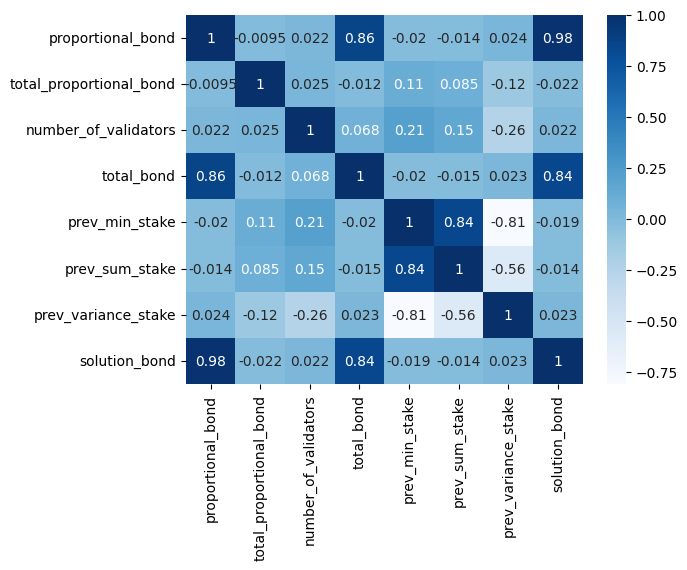

In [60]:
sns.heatmap(heatmap_df.corr(), cmap="Blues", annot=True)

In [55]:
features = ["proportional_bond", "total_bond"] # potentially add total proportional bond i.e grouping by validator
x = df.loc[:, features]
x_scaled = StandardScaler().fit_transform(x)
y = df.loc[:, ['solution_bond']]
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)

In [56]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge

In [57]:
lr = Ridge(alpha=0.5)
lr.fit(X_train, y_train)

Ridge(alpha=0.5)

In [58]:
mean_absolute_error(y_test, lr.predict(X_test))

11618542123689.914

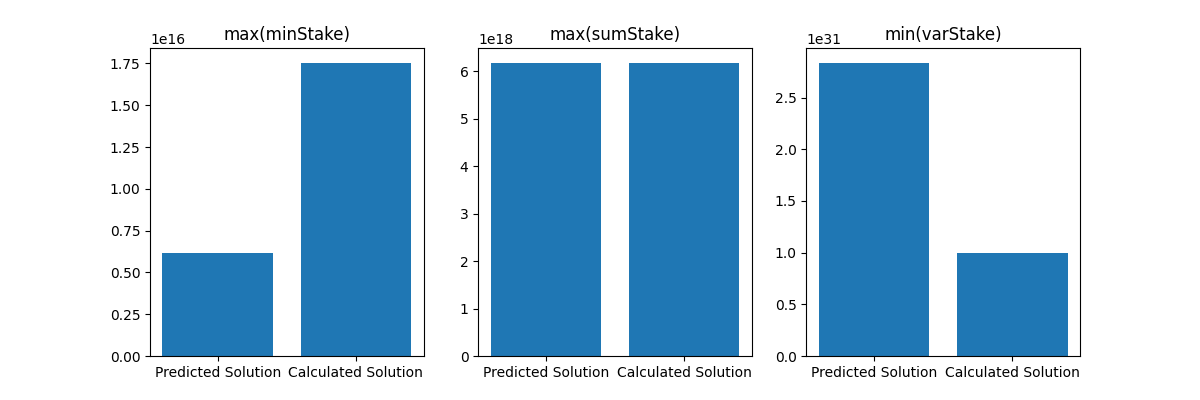

 - Using Optuna (hyperparameter tuning framework to optimise models (ridge, lasso, randomforest, gradientboosting)
      - Metrics such as mae/mse useless
      - Optimising now for scoring conditions
          - Results unfortunately still not satisfying
          - Potentially skewed due to "adjustment function"
              - Potentially introduce Model 3/make model 2 an ensemble model (hierarchical reconciliation?)
              - Potentially looking into NEAT (NeuroEvolution of Augmenting Topologies) for model selection. 
                  - Since data might not be informative enough for trivial models, NEAT might be able to produce more accurate/or more close predictions to the optimal solution.

In [71]:
def remove_outliers(df,columns,n_std):
    for col in columns:
        print('Working on column: {}'.format(col))
        
        mean = df[col].mean()
        sd = df[col].std()
        
        df = df[(df[col] <= mean+(n_std*sd))]
        
    return df

In [ ]:
dist_df = remove_outliers(df, df.columns, 3)

plt.hist(dist_df['solution_bond'], bins=150)
plt.show()

In [70]:
df.describe()

,era,proportional_bond,number_of_validators,total_bond,solution_bond,prev_min_stake,prev_sum_stake,prev_variance_stake,total_proportional_bond
count,1.375562e+07,1.375562e+07,1.375562e+07,1.375562e+07,1.375562e+07,1.375562e+07,1.375562e+07,1.375562e+07,1.375562e+07
mean,8.252170e+02,6.788024e+13,7.255954e+00,5.604362e+14,6.788024e+13,1.840798e+16,6.280664e+18,5.538542e+30,2.298065e+16
std,3.981434e+01,8.210643e+14,3.688399e+00,8.159204e+15,8.419745e+14,4.819267e+14,8.497941e+16,2.974017e+30,5.716232e+15
min,7.410000e+02,1.000000e+10,1.000000e+00,1.000000e+10,8.640000e+02,1.752004e+16,6.073632e+18,2.698389e+30,6.000010e+15
25%,7.970000e+02,3.243480e+11,4.000000e+00,2.040000e+12,2.064576e+11,1.806931e+16,6.203577e+18,3.463501e+30,1.942869e+16
50%,8.280000e+02,7.757500e+11,7.000000e+00,4.300000e+12,6.449956e+11,1.854853e+16,6.309903e+18,4.230353e+30,2.175178e+16
75%,8.590000e+02,2.545455e+12,1.000000e+01,1.299000e+13,2.347040e+12,1.880113e+16,6.348627e+18,9.399613e+30,2.481854e+16
max,8.890000e+02,4.899900e+16,1.600000e+01,4.461624e+17,4.899900e+16,1.895929e+16,6.426799e+18,1.571065e+31,6.198336e+16
